# **Uber Fare Prediction**
---

Objective of this Project is to:

Build Regression models using KNN-Models to predict the fare price of uber ride and evaluate the models & compare thier respective RMSE scores.

## Dataset Description
---

**During this project we are working with the edited data:**

- Original dataset comes from well-known kaggle repository: [Uber Fare - Kaggle](https://www.kaggle.com/datasets/yasserh/uber-fares-dataset)
- Edited Dataset can be found here: [Edited Uber Data](https://drive.google.com/file/d/1-Fr3OMbI1yKU_jNy-6cgXFJDVzjph3sn/view)




|Feature|Type|Descriptions|
|:--|:--|:--|
|`order_id`| `int` | a unique identifier for each trip|
|`pickup_time` | `str` | a class of pickup time. `04-10`, `10-16`, `16-22`, `22-04`. E.g. `04-10` means the pickup time is between 04.00 to 10.00|
| `pickup_longitude` | `float` | the longitude where the meter was engaged|
| `pickup_latitude` | `float` | the latitude where the meter was engaged|
| `dropoff_longitude` | `float` | the longitude where the meter was disengaged|
| `dropoff_latitude` | `float` | the latitude where the meter was disengaged|
| `passenger_count` | `float` | the number of passengers in the vehicle (driver entered value)|
| `fare_amount` | `int` | the cost of each trip in USD, (**our target**)|

## Modeling Workflow
---

 1. Import data to Python (10 pts)


In [1]:
# Dependencies

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from copy import deepcopy
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def read_data(fname: str) -> pd.DataFrame:
  """
    Reads CSV data, removes duplicate order IDs, and sets 'order_id' as index.

    :param fname: Path to the target data file
    :return: DataFrame with duplicates removed and 'order_id' set as index
    """
  df = pd.read_csv(fname)
  no_dupes = df.drop_duplicates(subset=["order_id"], keep="last")
  no_dupes.set_index("order_id", inplace=True)

  print(f"Data shape raw               : {df.shape}")
  print(f"Number of duplicate order id : {df['order_id'].duplicated().sum()}")
  print(f"Data shape after dropping    : {no_dupes.shape}")
  print(f"Data shape final             : {no_dupes.shape}")  # Fix: Use no_dupes instead of cleaned_df

  return no_dupes

In [3]:
data = read_data(fname='uber_edit.csv')

Data shape raw               : (194814, 8)
Number of duplicate order id : 0
Data shape after dropping    : (194814, 7)
Data shape final             : (194814, 7)


In [4]:
data.head()

,fare_amount,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,,
24238194,7.5,16-22,-73.999817,40.738354,-73.999512,40.723217,1.0
27835199,7.7,16-22,-73.994355,40.728225,-73.994710,40.750325,1.0
44984355,12.9,16-22,-74.005043,40.740770,-73.962565,40.772647,1.0
25894730,5.3,04-10,-73.976124,40.790844,-73.965316,40.803349,3.0
17610152,16.0,16-22,-73.925023,40.744085,-73.973082,40.761247,5.0


### 2. Data Preprocessing (60 pts)
---

**The processing pipeline**
```
2.1 Input-Output Split
2.2 Train-Valid-Test Split
2.3 Separate Numerical and Categorical Features
2.4 Numerical Imputation
2.5 Categorical Imputation
2.6 Preprocess Categorical Features
2.7 Join the Data
2.8 Feature Engineering the Data
2.9 Create a Preprocessing Function
```

#### 2.1. Input-Output Split (6 pts)
---

- We're going to split input & output according to the modeling objective.
- Create a function to split the input & output

In [5]:
################################################

#####              FUNCTION               ######

################################################


def split_input_output(data: pd.DataFrame, target_col: pd.Series) -> pd.DataFrame:
  """
  :param DataFrame data: targeted DataFrame
  :param str target_col: collumns to be dropped
  """
  y = data[target_col]
  X = data.drop(target_col, axis=1)

  # print out data shape
  print(f"(X) Input shape: {X.shape}")
  print(f"(y) Output shape: {y.shape}")

  return X, y


def split_train_test(input: pd.DataFrame,
                     output: pd.DataFrame,
                     test_size: float,
                     seed: int) -> pd.DataFrame:
  """
  :param input: input features
  :param output: output features
  :param float test_size: distribution of test batch from 0 - 1
  """
  from sklearn.model_selection import train_test_split

  # first batch Train and temp
  X_train, X_temp, y_train, y_temp = train_test_split(input, output,
                                                              test_size=test_size,
                                                              random_state=seed)
  return X_train, X_temp, y_train, y_temp

def split_cat_num_feature(dataframe) -> pd.DataFrame:
  """
  :params data: DataFrame of input features
  :params num_cols: numerical columns in input dataframe
  :param cat_cols: categorical columns in input dataframe
  """
  # select columns for categorical and numerical
  num_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
  cat_cols = dataframe.select_dtypes(exclude=[np.number]).columns.tolist()

  # selecting dataframe based on their features
  cat_df = dataframe.drop(num_cols, axis=1)
  num_df = dataframe.drop(cat_cols, axis=1)

  return num_df, cat_df

In [6]:
X, y = split_input_output(data=data,
                          target_col='fare_amount')

(X) Input shape: (194814, 6)
(y) Output shape: (194814,)


In [7]:
X.head()

,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,
24238194,16-22,-73.999817,40.738354,-73.999512,40.723217,1.0
27835199,16-22,-73.994355,40.728225,-73.994710,40.750325,1.0
44984355,16-22,-74.005043,40.740770,-73.962565,40.772647,1.0
25894730,04-10,-73.976124,40.790844,-73.965316,40.803349,3.0
17610152,16-22,-73.925023,40.744085,-73.973082,40.761247,5.0


In [8]:
y.head()

order_id
24238194     7.5
27835199     7.7
44984355    12.9
25894730     5.3
17610152    16.0
Name: fare_amount, dtype: float64

#### 2.2. Train-Valid-Test Split (6 pts)
---

- Now, we want to split the data before modeling. We are using the normal proportion of **train (80%), valid (10%), and test (10%)**

- For all splits we use **seed = 123**


In [9]:
# Split the data
# First, split the train & not train
X_train, X_not_train, y_train, y_not_train = split_train_test(X, y, 0.2, 123)

# Then, split the valid & test
X_valid, X_test, y_valid, y_test = split_train_test(X_not_train, y_not_train, 0.5, 123)

# print out result
print(f"X train shape:{X_train.shape} with portion of {round(len(X_train) / len(X),4)}")
print(f"y train shape:{y_train.shape} with portion of {round(len(y_train) / len(y),4)}")
print("")

print(f"X valid shape: {X_valid.shape} with portion of {round(len(X_valid) / len(X),4)}")
print(f"y valid shape: {y_valid.shape} with portion of {round(len(y_valid) / len(y),4)}")
print("")

print(f"X test  shape: {X_test.shape} with portion of {round(len(X_test) / len(X),4)}")
print(f"y test  shape: {y_test.shape} with portion of {round(len(y_test) / len(y),4)}")

X train shape:(155851, 6) with portion of 0.8
y train shape:(155851,) with portion of 0.8

X valid shape: (19481, 6) with portion of 0.1
y valid shape: (19481,) with portion of 0.1

X test  shape: (19482, 6) with portion of 0.1
y test  shape: (19482,) with portion of 0.1


In [10]:
X_train.head()

,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,
51655713,16-22,-73.979392,40.735734,-73.906281,40.745539,2.0
37525839,16-22,-73.986575,40.761473,-73.981880,40.768660,5.0
55058970,16-22,-73.972533,40.782260,-73.952761,40.708980,1.0
15663447,10-16,-73.979967,40.751612,-73.976313,40.758427,6.0
13325650,16-22,-73.976192,40.744026,-73.980935,40.733946,1.0


In [11]:
X_valid.head()

,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,
21821145,22-04,-73.977407,40.787420,-73.981681,40.779710,1.0
29648992,16-22,-73.968118,40.762640,-73.981218,40.743978,2.0
7294406,10-16,-74.002565,40.739638,-74.002530,40.748657,3.0
36199153,10-16,-73.990273,40.752152,-73.965520,40.763480,3.0
24870627,10-16,-73.982379,40.748521,-73.975392,40.758517,1.0


In [12]:
X_test.head()

,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,
40871174,16-22,-73.996420,40.721390,-73.991843,40.726090,2.0
31187540,16-22,-73.981248,40.769185,-73.973245,40.785022,1.0
30455562,22-04,-73.982342,40.753909,-73.949045,40.774976,1.0
33371988,04-10,-73.990311,40.761501,-73.973953,40.764660,3.0
6834592,22-04,-73.983022,40.777505,-73.991477,40.750002,6.0


#### 2.3. Separate Numerical and Categorical Features
---

- separate the data into numerical data & categorical data before pre-processing

In [13]:
# Split the data
X_train_num, X_train_cat = split_cat_num_feature(X_train)
print(f"Data num shape: {X_train_num.shape}")
print(f"Data cat shape: {X_train_cat.shape}")

Data num shape: (155851, 5)
Data cat shape: (155851, 1)


In [14]:
X_train_num.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,
51655713,-73.979392,40.735734,-73.906281,40.745539,2.0
37525839,-73.986575,40.761473,-73.981880,40.768660,5.0
55058970,-73.972533,40.782260,-73.952761,40.708980,1.0
15663447,-73.979967,40.751612,-73.976313,40.758427,6.0
13325650,-73.976192,40.744026,-73.980935,40.733946,1.0


In [15]:
X_train_cat.head()

,pickup_time
order_id,
51655713,16-22
37525839,16-22
55058970,16-22
15663447,10-16
13325650,16-22


## EDA before Preprocessing
---

Objectives:

- Find if any features have missing values: In case of any, we will try to impute this value to learn sk-learn imputation method
- Analyze feature statistical distribution and Pearson correlation


In [16]:
################################################

#####              FUNCTION               ######

################################################



def num_imputer_fit(data):
  """
  Function to fit & transform numerical imputers
  - input:
  :params data: the input data (pandas DataFrame)

  - outputs: the fitted imputer
  """
  imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
  imp_median.fit(data)
  return imp_median

def numerical_imputer_transform(data, imputer):
  """
  Function to transform the data using the fitted numerical imputer
  - input:
  :params data: the input data (pandas DataFrame)
  :params imputer: the fitted numerical imputer (sklearn object)

  - output: imputed_data: the imputed data (pandas DataFrame)
  """
  num_feat = data.columns
  df_num = imputer.transform(data)
  imputed_DataFrame = pd.DataFrame(df_num, columns=num_feat,
                              index=data.index)

  return imputed_DataFrame



def cat_imputer_fit(data):
  """
  Replace missing categorical values(defined by "-") using SimpleImputer from Scikit-learn
  The imputed value will be a constant string "UNKNOWN".

  inputs:
  :params data: Pandas DataFrame containing the categorical data

  oputput:
  imputer_cat : The fitted SimpleImputer object
  """
  # set up imputer
  imputer_cat = SimpleImputer(missing_values="-", strategy="constant",
                                  fill_value="UNKNOWN")
  imputer_cat.fit(data)
  return imputer_cat

def cat_imputer_transform(data, cat_imputer):
  """
  Function to transform data using a fitted categorical imputer.

  - inputs:
  :params data : DataFrame of categorical features
  :params imputer : Sklearn SimpleImputer object for categorical features

  - output:
  df_cat_imputed: The imputed data as a pandas DataFrame
  """
  cat_cols = data.columns
  cat_idx = data.index

  df_cat = cat_imputer.transform(data);

  # initatate imputation
  df_cat_imputed = pd.DataFrame(df_cat, columns=cat_cols, index=cat_idx )

  return df_cat_imputed


def cat_encoder_fit(data):
    """
    Function to fit a OneHotEncoder on categorical features of a DataFrame.

    - input :
    data : Categorical DataFrame of un-encoded things

    - output:
    encoder : The fitted OneHotEncoder object
    """
    # Create an encoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the data
    encoder.fit(data)

    return encoder

def cat_encoder_transform(data, encoder):
  """
  Function to transform data using a fitted OneHotEncoder.

   - inputs:
   :params data : Pandas DataFrame, the input data
   :params encoder : The fitted encoder (Sklearn OneHotEncoder object)

   - output:
   encoded_data: Transformed (encoded) data as a pandas DataFrame
  """
  # Transform the data using the fitted encoder
  encoded = encoder.transform(data)

  # Get feature names from the encoder and use as columns
  encoded_data = pd.DataFrame(encoded,
                              columns=encoder.get_feature_names_out(
                                  input_features=data.columns),
                              index=data.index)

  return encoded_data

In [17]:
100 * (X_train.isna().sum(0) / len(X_train))

pickup_time          0.000000
pickup_longitude     0.000000
pickup_latitude      0.000000
dropoff_longitude    0.000000
dropoff_latitude     0.000000
passenger_count      0.606348
dtype: float64

- We will impute all these variables if there is any missing value

- First, check the numerical features distribution

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

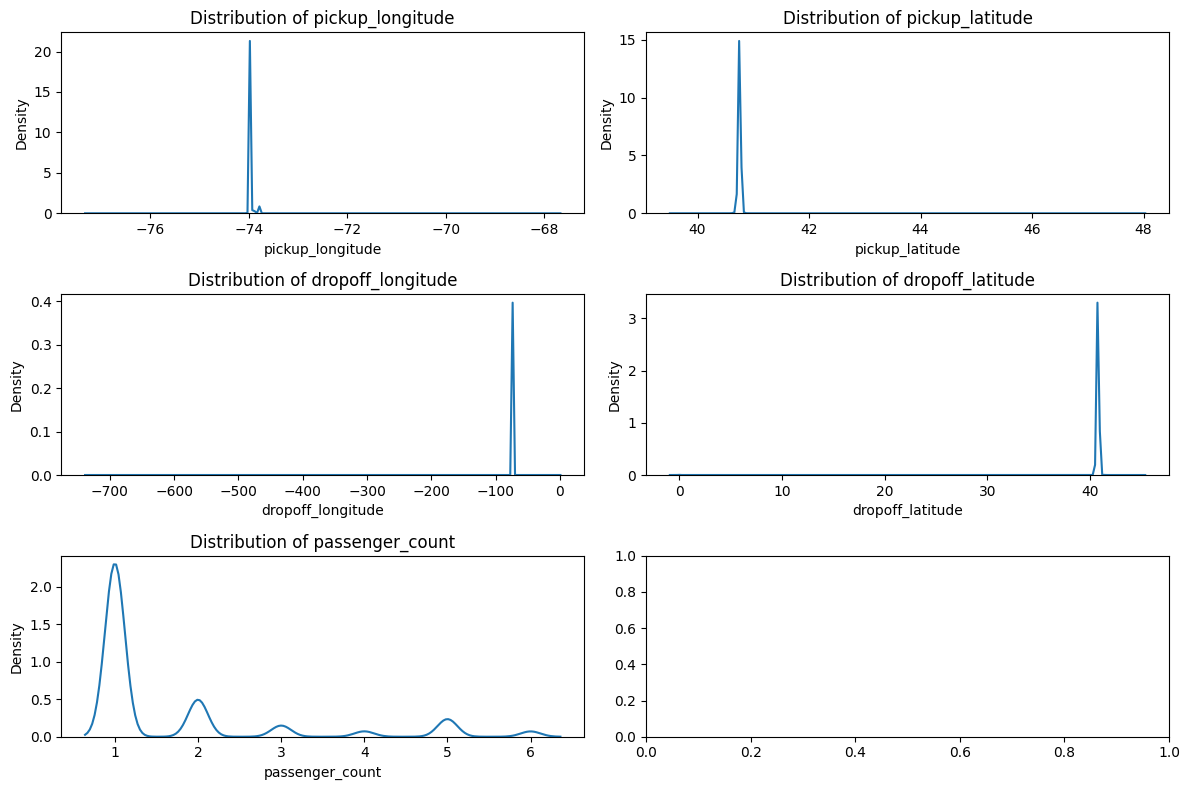

In [19]:
# Plot histogram
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = ax.flatten()

for i, col in enumerate(X_train_num.columns):
    sns.kdeplot(X_train_num[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

- All the distribution are skewed, we can impute a missing value by its features median.

- Next, explore the `pickup_time`

In [20]:
X_train['pickup_time'].value_counts(normalize=True)

pickup_time
16-22    0.328160
10-16    0.286376
22-04    0.221648
04-10    0.157599
-        0.006217
Name: proportion, dtype: float64

- There's a missing value with symbol `'-'` in `pickup_time`,
- We can impute the missing value with `UNKNOWN`

- Explore the relation between `pickup_time` and `fare`

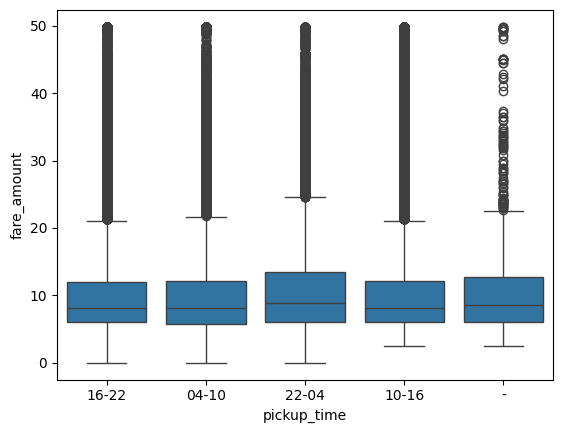

In [21]:
# Create a boxplot
sns.boxplot(data=data[data['fare_amount'] < 50],
            x='pickup_time',
            y='fare_amount')
plt.show()

- There is no significant fare different between `pickup_time`.
- We can perform a one hot encoding for this data.

**Conclusion for preprocessing**
- Impute the missing `passenger_counts` with its median
- Impute the missing `pickup_time` with `'UNKNOWN'`
- Feature engineering the `dropoff` and `pickup` coordinate to be a distance between pickup and dropoff. We can use an Euclidean distance for simplicity.

#### 2.4. Numerical Imputation
---

- Now, let's perform a numerical imputation
- First check the missing value of the numerical data

In [22]:
X_train_num.isna().sum(0)

pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
passenger_count      945
dtype: int64

- Perform imputation

In [23]:
# Get the numerical imputer
num_imputer = num_imputer_fit(X_train_num)
X_train_num_imputed = numerical_imputer_transform(X_train_num, num_imputer)

In [24]:
X_train_num_imputed.isna().sum(0)

pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

#### 2.5. Categorical Imputation
---

- Next, let's perform the categorical imputation

In [25]:
# Check missing value
X_train_cat.value_counts(normalize=True)

pickup_time
16-22          0.328160
10-16          0.286376
22-04          0.221648
04-10          0.157599
-              0.006217
Name: proportion, dtype: float64

- Perform imputation

In [26]:
# Perform categorical imputation
cat_imputer = cat_imputer_fit(X_train_cat)
X_train_cat_imputed = cat_imputer_transform(X_train_cat, cat_imputer)

In [27]:
# Validate
X_train_cat_imputed.value_counts(normalize=True)

pickup_time
16-22          0.328160
10-16          0.286376
22-04          0.221648
04-10          0.157599
UNKNOWN        0.006217
Name: proportion, dtype: float64

Great!

#### 2.6. Preprocess Categorical Features
---

- Perform imputation

In [28]:
# Perform categorical imputation
cat_encoder = cat_encoder_fit(X_train_cat_imputed)
X_train_cat_encoded = cat_encoder_transform(X_train_cat_imputed, cat_encoder)

In [29]:
# Validate
print('Original shape:', X_train_cat_imputed.shape)
print('Encoded shape :', X_train_cat_encoded.shape)

Original shape: (155851, 1)
Encoded shape : (155851, 5)


In [30]:
# Validate
X_train_cat_encoded.head()

,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN
order_id,,,,,
51655713,0.0,0.0,1.0,0.0,0.0
37525839,0.0,0.0,1.0,0.0,0.0
55058970,0.0,0.0,1.0,0.0,0.0
15663447,0.0,1.0,0.0,0.0,0.0
13325650,0.0,0.0,1.0,0.0,0.0


In [31]:
# Validate
X_train_cat_imputed.head()

,pickup_time
order_id,
51655713,16-22
37525839,16-22
55058970,16-22
15663447,10-16
13325650,16-22


Great!

#### 2.7. Join the data
---

- After all the data is filled (numerically), we can join the data


In [32]:
def concat_data(num_df, cat_df):
  """
  join numerical and categorical data

  - inputs :
  :params num_data : DataFrame, numerical data
  :params cat_data : DataFrame, categorical data

  - output:
  DataFrame, concatenated data
  """
  joined_df = pd.concat([num_df, cat_df], axis=1)

  print(f"numerical data shape: {num_df.shape}")
  print(f"categorical data shape: {cat_df.shape}")
  print(f"Joined data shape: {joined_df.shape}")

  return joined_df

In [33]:
# Concat the data
X_train_concat = concat_data(X_train_num_imputed, X_train_cat_encoded)

numerical data shape: (155851, 5)
categorical data shape: (155851, 5)
Joined data shape: (155851, 10)


In [34]:
# Validate
X_train_concat.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN
order_id,,,,,,,,,,
51655713,-73.979392,40.735734,-73.906281,40.745539,2.0,0.0,0.0,1.0,0.0,0.0
37525839,-73.986575,40.761473,-73.981880,40.768660,5.0,0.0,0.0,1.0,0.0,0.0
55058970,-73.972533,40.782260,-73.952761,40.708980,1.0,0.0,0.0,1.0,0.0,0.0
15663447,-73.979967,40.751612,-73.976313,40.758427,6.0,0.0,1.0,0.0,0.0,0.0
13325650,-73.976192,40.744026,-73.980935,40.733946,1.0,0.0,0.0,1.0,0.0,0.0


Great!

#### 2.8. Feature engineering the data
---

- Now, `pickup` and `dropoff` coordinate is not an explicit features.
- We can create a better feature called by `distance` to summarize the `pickup` and `dropoff` coordinate.

In [35]:
def map_distance(data):
  """
    Computes Euclidean distance between pickup and dropoff coordinates, adds it as a column, and drops the original coordinate columns.

    :param data: DataFrame containing pickup and dropoff coordinates
    :return: DataFrame with distance column added and original coordinate columns removed
  """

  ### list of numerical feature name
  # None__pickup_longitude [0]
  # None__pickup_latitude  [1]
  # None__dropoff_longitude[2]
  # None__dropoff_latitude [3]

  # X pickup (latitude) & Y dropoff (longitude) part of Eclidean distance formula
  x_lat = (data[data.columns[1]] - data[data.columns[3]])**2
  y_long = (data[data.columns[0]] - data[data.columns[2]])**2

  # caluclate distance
  distance = (x_lat + y_long)**0.5

  # add distance as column
  data["distance"] = distance

  # clean up dataset - drop pickup and dropoff latitude and longitude
  # select columns to delete
  col_names = []
  for i in range(0,4,1):
    col_names.append(data.columns[i])

  mapped_df = data.drop(columns=col_names)

  # validation feedback
  #print(f"Original data shape: {data.shape}")
  #print(f"Original data shape: {mapped_df.shape}")

  return mapped_df

In [36]:
# Calculate the distance
X_train_concat_fe = map_distance(X_train_concat)

In [37]:
# Validate
X_train_concat_fe.head()

,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN,distance
order_id,,,,,,,
51655713,2.0,0.0,0.0,1.0,0.0,0.0,0.073766
37525839,5.0,0.0,0.0,1.0,0.0,0.0,0.008585
55058970,1.0,0.0,0.0,1.0,0.0,0.0,0.075901
15663447,6.0,0.0,1.0,0.0,0.0,0.0,0.007733
13325650,1.0,0.0,0.0,1.0,0.0,0.0,0.011140


- And finally, we standardize the data so that it can perform well during model optimization

In [38]:

def fit_scaler(data):
  """
  Function to perform scaling with SKlearn - preprocessing library
  - input:
  :params data: concated Dataframe of categorical & numerical

  - output:
  scaler: standardscaler based on input dataframe
  """
  scaler = StandardScaler()

  std_scaler = scaler.fit(data)

  return std_scaler


def transform_scaler(data, scaler):
    """
    Function to transform concated input dataframe
    - input:
    :params data: concated Dataframe of categorical & numerical
    :params scaler: standardscaler based on input dataframe

    - output:
    fina_df: standardized dataframe
    """
    scaled_data = scaler.transform(data)

    scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

    return scaled_df

In [39]:
# Fit the scaler
scaler = fit_scaler(X_train_concat_fe)

# Transform the scaler
X_train_clean = transform_scaler(X_train_concat_fe, scaler)

In [40]:
# Validate
X_train_clean.describe().round(4)

,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN,distance
count,155851.0000,155851.0000,155851.0000,155851.0000,155851.0000,155851.0000,155851.0000
mean,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-0.5267,-0.4325,-0.6335,-0.6989,-0.5336,-0.0791,-0.0383
25%,-0.5267,-0.4325,-0.6335,-0.6989,-0.5336,-0.0791,-0.0340
50%,-0.5267,-0.4325,-0.6335,-0.6989,-0.5336,-0.0791,-0.0311
75%,0.2412,-0.4325,1.5786,1.4308,-0.5336,-0.0791,-0.0256
max,3.3130,2.3120,1.5786,1.4308,1.8739,12.6427,218.5245


Great!

#### 2.9. Create the preprocess function
---

- Now, let's summarize the steps and create a function to automatically preprocess other data splits

In [41]:
def preprocess_data(data, num_cols, cat_cols, num_imputer, cat_imputer, cat_encoder, scaler):
  """
  Preprocesses data by imputing missing values, encoding categorical features, calculating distance, and scaling.

  :param data: Input DataFrame
  :param num_cols: List of numerical column names
  :param cat_cols: List of categorical column names
  :param num_imputer: Imputer for numerical data
  :param cat_imputer: Imputer for categorical data
  :param cat_encoder: Encoder for categorical data
  :param scaler: Scaler for numerical data
  :return: Preprocessed DataFrame
  """
  num_df = data[num_cols] ; cat_df = data[cat_cols]

  num_df_imputed = numerical_imputer_transform(num_df, num_imputer)

  cat_df_imputed = cat_imputer_transform(cat_df, cat_imputer)

  cat_encoder = cat_encoder_fit(cat_df_imputed)

  cat_encoded = cat_encoder_transform(cat_df_imputed, cat_encoder)

  joined_df = pd.concat([num_df_imputed, cat_encoded], axis=1)

  mapped_df = map_distance(joined_df)

  df_cleaned = transform_scaler(mapped_df, scaler)

  # validation print out
  print(f"Original datashape: {data.shape}")
  print(f"Numerical datashape: {num_df.shape}")
  print(f"Categorical datashape: {cat_df.shape}")
  print(f"final DF datashape: {df_cleaned.shape}")


  return df_cleaned

In [42]:
# Preprocess the data training again just to check
X_train_clean = preprocess_data(
    data=X_train,
    num_cols=['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
    cat_cols=['pickup_time'],
    num_imputer = num_imputer,
    cat_imputer = cat_imputer,
    cat_encoder = cat_encoder,
    scaler = scaler
)

Original datashape: (155851, 6)
Numerical datashape: (155851, 5)
Categorical datashape: (155851, 1)
final DF datashape: (155851, 7)


In [43]:
# Validate
print('Original data shape:', X_train.shape)
print('Cleaned data shape :', X_train_clean.shape)
X_train_clean.head()

Original data shape: (155851, 6)
Cleaned data shape : (155851, 7)


,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN,distance
order_id,,,,,,,
51655713,0.241233,-0.432531,-0.633481,1.430838,-0.533634,-0.079097,-0.013978
37525839,2.545080,-0.432531,-0.633481,1.430838,-0.533634,-0.079097,-0.035436
55058970,-0.526715,-0.432531,-0.633481,1.430838,-0.533634,-0.079097,-0.013275
15663447,3.313029,-0.432531,1.578579,-0.698891,-0.533634,-0.079097,-0.035716
13325650,-0.526715,-0.432531,-0.633481,1.430838,-0.533634,-0.079097,-0.034594


In [44]:
# Transform other set of data
print("Valid Data Shape")
X_valid_clean = preprocess_data(
    data=X_valid,
    num_cols=['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
    cat_cols=['pickup_time'],
    num_imputer = num_imputer,
    cat_imputer = cat_imputer,
    cat_encoder = cat_encoder,
    scaler = scaler
)

print("")
print("")
print("Test Data Shape")
X_test_clean = preprocess_data(
    data=X_test,
    num_cols=['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
    cat_cols=['pickup_time'],
    num_imputer = num_imputer,
    cat_imputer = cat_imputer,
    cat_encoder = cat_encoder,
    scaler = scaler
)

Valid Data Shape
Original datashape: (19481, 6)
Numerical datashape: (19481, 5)
Categorical datashape: (19481, 1)
final DF datashape: (19481, 7)


Test Data Shape
Original datashape: (19482, 6)
Numerical datashape: (19482, 5)
Categorical datashape: (19482, 1)
final DF datashape: (19482, 7)


In [45]:
X_valid_clean.describe()

,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN,distance
count,19481.000000,19481.000000,19481.000000,19481.000000,19481.000000,19481.000000,19481.000000
mean,-0.004947,-0.001999,0.009437,-0.005015,-0.002585,-0.001386,0.002344
std,0.997967,0.998143,1.004431,0.998176,0.998288,0.991279,0.898812
min,-0.526715,-0.432531,-0.633481,-0.698891,-0.533634,-0.079097,-0.038262
25%,-0.526715,-0.432531,-0.633481,-0.698891,-0.533634,-0.079097,-0.034097
50%,-0.526715,-0.432531,-0.633481,-0.698891,-0.533634,-0.079097,-0.031074
75%,0.241233,-0.432531,1.578579,1.430838,-0.533634,-0.079097,-0.025604
max,3.313029,2.311971,1.578579,1.430838,1.873944,12.642664,27.772425


In [46]:
X_test_clean.describe()

,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN,distance
count,19482.000000,19482.000000,19482.000000,19482.000000,19482.000000,19482.000000,19482.000000
mean,0.003462,0.003050,-0.001383,-0.005488,0.006162,-0.005961,-0.004135
std,1.008163,1.002883,0.999371,0.998000,1.004128,0.961831,0.790673
min,-0.526715,-0.432531,-0.633481,-0.698891,-0.533634,-0.079097,-0.038262
25%,-0.526715,-0.432531,-0.633481,-0.698891,-0.533634,-0.079097,-0.034054
50%,-0.526715,-0.432531,-0.633481,-0.698891,-0.533634,-0.079097,-0.031049
75%,0.241233,-0.432531,1.578579,1.430838,-0.533634,-0.079097,-0.025484
max,3.313029,2.311971,1.578579,1.430838,1.873944,12.642664,27.772940


### 3. Training Machine Learning Models
---

```
3.1 Prepare train & evaluate model function
3.2 Train & evaluate several models
3.3 Choose the best model
```

#### 3.1. Preprare train & evaluate model function (10 pts)
---

- Before modeling, let's prepare function to train & evaluate model

In [47]:
################################################

#####              FUNCTION               ######

################################################

def train_model(estimator:BaseEstimator, input, output):
  estimator.fit(input, output)

def evaluate_model(estimator:BaseEstimator, in_train, out_train, in_val, out_val):
  # training
  y_train_predict = estimator.predict(in_train)
  rmse_train = mean_squared_error(out_train, y_train_predict)**0.5

  # validation
  y_valid_predict = estimator.predict(in_val)
  rmse_valid = mean_squared_error(out_val, y_valid_predict)**0.5

  return rmse_train, rmse_valid

def hyperparameter_search_knn(X_train, y_train, min_neighbors, max_neighbors, steps,
                              cv, scoring):
    """
    Perform hyperparameter search for KNeighborsRegressor.

    :param X_train: Training features
    :param y_train: Training target
    :param min_neighbors: Minimum number of neighbors
    :param max_neighbors: Maximum number of neighbors
    :param cv: Number of cross-validation folds
    :param scoring: Scoring technique
    :return: Best hyperparameter combination
    """
    knn = KNeighborsRegressor()
    grid = [i for i in range(min_neighbors, max_neighbors + steps)]

    param_grid = {
        'n_neighbors': grid,
        'weights': ['uniform', 'distance']
    }

    grid_knn = GridSearchCV(knn, param_grid, cv=cv, scoring=scoring)
    grid_knn.fit(X_train, y_train)

    best_parameters = grid_knn.best_params_

    print(f"Best hyperparameter: {best_parameters}")

    return best_parameters

#### 3.2. Train and Evaluate Several Models
---

- Now, let's train & evaluate several models
- You should check, which one of the following model is the best model

  1. Baseline model
  2. k-NN with k=1
  3. k-NN with k=100
  4. k-NN with k=200
  5. k-NN with k=500
  6. k-NN with Hyperparameter search

**Hyperparameter Grid Search**

---



In [48]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [79]:
best_params = hyperparameter_search_knn(X_train_clean, y_train, 10, 150, 10, cv=5
                                        , scoring= 'neg_root_mean_squared_error')
print(best_params)

Best hyperparameter: {'n_neighbors': 27, 'weights': 'uniform'}
{'n_neighbors': 27, 'weights': 'uniform'}


**Create Regressor Model**

---

In [49]:
reg_1 = DummyRegressor(strategy="mean")
reg_2 = KNeighborsRegressor(n_neighbors=1)
reg_3 = KNeighborsRegressor(n_neighbors=100)
reg_4 = KNeighborsRegressor(n_neighbors=200)
reg_5 = KNeighborsRegressor(n_neighbors=500)
reg_6 = KNeighborsRegressor(n_neighbors=27) # After Hyperparameter tuning using grid search

In [50]:
# Train the model (JUST RUN THE CODE)
train_model(reg_1, X_train_clean, y_train)
train_model(reg_2, X_train_clean, y_train)
train_model(reg_3, X_train_clean, y_train)
train_model(reg_4, X_train_clean, y_train)
train_model(reg_5, X_train_clean, y_train)
train_model(reg_6, X_train_clean, y_train) # diluar kelas, used hyperparameter grid search.

In [51]:
# Return validation (JUST RUN THE CODE)
import time

for reg in [reg_1, reg_2, reg_3, reg_4, reg_5, reg_6]:
    t0 = time.time()

    # Generate the rmse
    rmse_train, rmse_valid = evaluate_model(estimator=reg,
                                            in_train=X_train_clean,
                                            out_train=y_train,
                                            in_val=X_valid_clean,
                                            out_val=y_valid)

    # Logging
    elapsed = time.time() - t0
    print(f'model : {str(reg):40s} '
          f'| RMSE train: {rmse_train:.4f} '
          f'| RMSE valid: {rmse_valid:.4f} '
          f'| Time elapsed: {elapsed*1000:.2f} ms')

model : DummyRegressor()                         | RMSE train: 8.9221 | RMSE valid: 8.8614 | Time elapsed: 4.25 ms
model : KNeighborsRegressor(n_neighbors=1)       | RMSE train: 1.3980 | RMSE valid: 5.4116 | Time elapsed: 44216.65 ms
model : KNeighborsRegressor(n_neighbors=100)     | RMSE train: 3.9594 | RMSE valid: 3.9783 | Time elapsed: 50998.88 ms
model : KNeighborsRegressor(n_neighbors=200)     | RMSE train: 4.1505 | RMSE valid: 4.1420 | Time elapsed: 71469.16 ms
model : KNeighborsRegressor(n_neighbors=500)     | RMSE train: 4.6286 | RMSE valid: 4.6223 | Time elapsed: 108649.77 ms
model : KNeighborsRegressor(n_neighbors=27)      | RMSE train: 3.7829 | RMSE valid: 3.9442 | Time elapsed: 34305.09 ms


#### 3.3. Choose the best model
---

From the previous results, which one is the best model?

- Based on the lowest RMSE value of valid split, KNN model with best parameter
from GridSearchCV are the best to predict fare price, followed by k-NN with 100 neighboors. This means our best model on average have a fare prediction error of 3.94 USD. Model with n = 100 neighboors have a similar performance where error in fare prediction was calculated at 3.98 USD.

- An important metric too look is processing time of prediction. This may be crucial due to the time delay between user gving their input on their pickup & dropoff location to actual price being shown on their screen. This metrics shows the performance advantage of the hyperparameter model, prediction time using k-NN with best params is roughly 68% faster than n = 100 neighboors without any significant performance reduction.

- Another metric of error assessment is not use in this exercise due to time limitation. Therefore, we only look at RMSE as the metrics due to their interpretability for the actual unit being observed. The insights of RMSE can be drived to presentable business metrics

In [52]:
# choose best model
reg_best = reg_6

### 4. Predictions & Evaluations
---

```
4.1 Predict & Evaluate on the Train Data
4.2 Predict & Evaluate on the Test Data
```

#### 4.1. Predict & evaluate on train data
---

In [53]:
y_train_pred = reg_best.predict(X_train_clean)

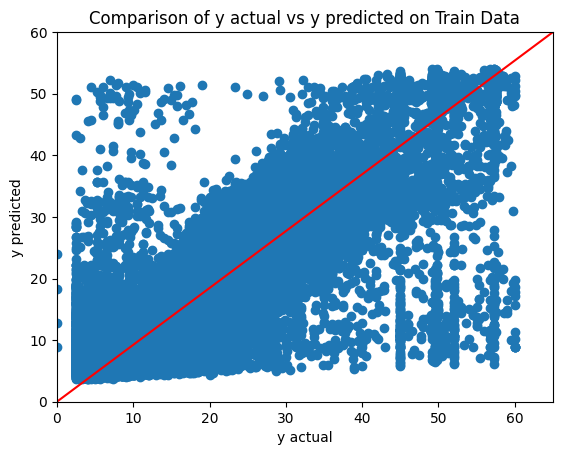

In [54]:
# Visualize & compare the prediction
plt.scatter(y_train, y_train_pred)
xlim = 65 ; ylim= 60
plt.plot([0, xlim], [0, ylim], c='red')
plt.xlim(0, xlim); plt.ylim(0, ylim)
plt.xlabel('y actual'); plt.ylabel('y predicted')
plt.title('Comparison of y actual vs y predicted on Train Data')
plt.show()

#### 4.2. Predict & evaluate on test data
---

In [55]:
y_test_pred = reg_best.predict(X_test_clean)

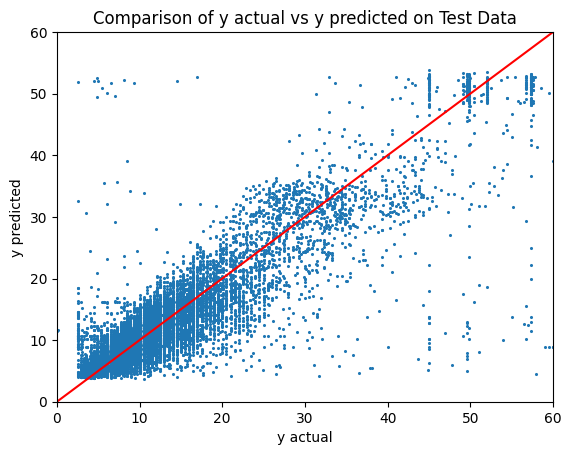

In [56]:
# Visualize & compare the prediction
plt.scatter(y_test, y_test_pred, s=1.5) ## picked from
xlim = 60 ; ylim= xlim
plt.plot([0, xlim], [0, ylim], c='red')
plt.xlim(0, xlim); plt.ylim(0, ylim)
plt.xlabel('y actual'); plt.ylabel('y predicted')
plt.title('Comparison of y actual vs y predicted on Test Data')
plt.show()

# **Business Impact**

Lets investigate the impact to our business in case of our model would be deployed in the test case

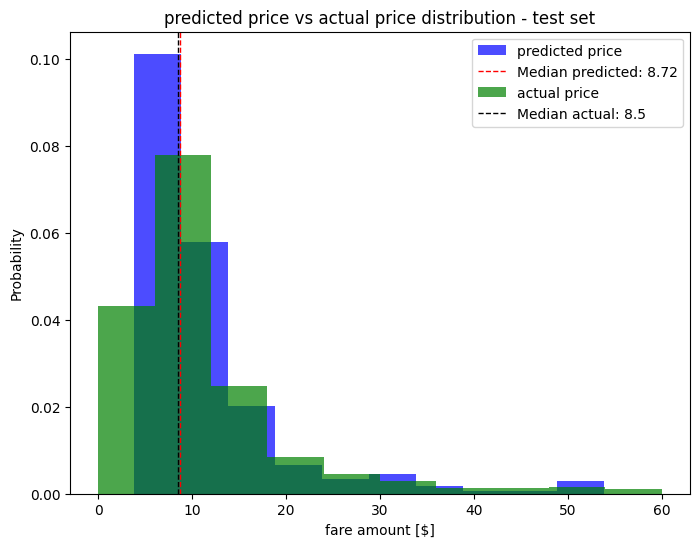

In [58]:
# setting figure size
plt.figure(figsize=(8,6))

# plotting for prediction
plt.hist(y_test_pred, color="blue", label="predicted price", alpha=0.7, density=True)
med_predict = np.median(y_test_pred)
plt.axvline(med_predict, color='red', linestyle='dashed', linewidth=1, label=f'Median predicted: {round(med_predict, 2)}')

# plotting for ground truth
plt.hist(y_test, color="green", label="actual price", alpha=0.7, density=True)
med_label = np.median(y_test)
plt.axvline(med_label, color='black', linestyle='dashed', linewidth=1, label=f'Median actual: {round(med_label, 2)}')

plt.title("predicted price vs actual price distribution - test set")
plt.ylabel("Probability")
plt.xlabel("fare amount [$]")
plt.legend()
plt.show()

In [59]:
# Histogram did showed tedency of our model to dsitribute the price to the lower end (below roughly 15$)
threshold = 15
print("num of instances of fare prediction below $12")
pred_hsit = y_test_pred[y_test_pred > threshold] ; print(len(pred_hsit))
print(" ")
print("num of instances of actual fare below $12")
actu_hist = y_test[y_test > threshold] ; print(len(actu_hist))

num of instances of fare prediction below $12
3280
 
num of instances of actual fare below $12
3470


In [60]:
# Calculate prediction difference, target should be near 0
differene_fare = y_test_pred - y_test
print(differene_fare.sum())

-474.5300000000008


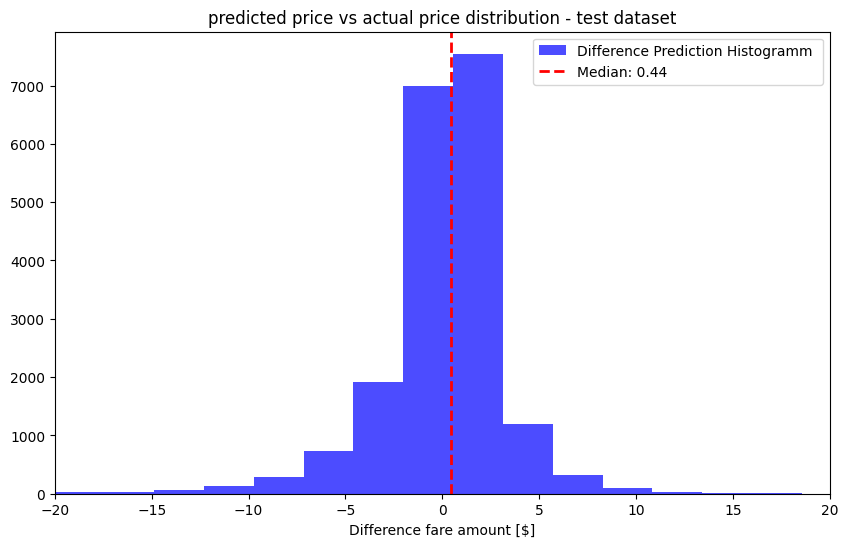

In [61]:
difference_fare_df = y_test_pred - y_test
plt.figure(figsize=(10,6))
plt.hist(difference_fare_df, color="blue", bins=40, label="Difference Prediction Histogramm ", alpha=0.7, density=False)

# Calculate the median and draw a vertical line on it
median_difference = np.median(difference_fare_df)
plt.axvline(median_difference, color='r', linestyle='dashed', linewidth=2, label=f'Median: {round(median_difference, 2)}')

plt.title("predicted price vs actual price distribution - test dataset")
plt.xlabel("Difference fare amount [$]")
plt.xlim(-20, 20)
plt.legend()
plt.show()

The result showed, the deployment of the best model will give a total revenue of **-$ 474.5** than the actual price. This model will need some minor adjustment due to the negative impact on business revenue. We suggest to include a feature indicating wether the price is affected by coupons since the availability of a coupons can be a deciding factor when choosing a ride hailing service

# **Visualization of Some Trips**


---
Help from ChatGPT


In [62]:
pip install pandas geopandas matplotlib contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 40.4 MB/s eta 0:00:00


In [63]:
data.head(2)

,fare_amount,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,,
24238194,7.5,16-22,-73.999817,40.738354,-73.999512,40.723217,1.0
27835199,7.7,16-22,-73.994355,40.728225,-73.994710,40.750325,1.0


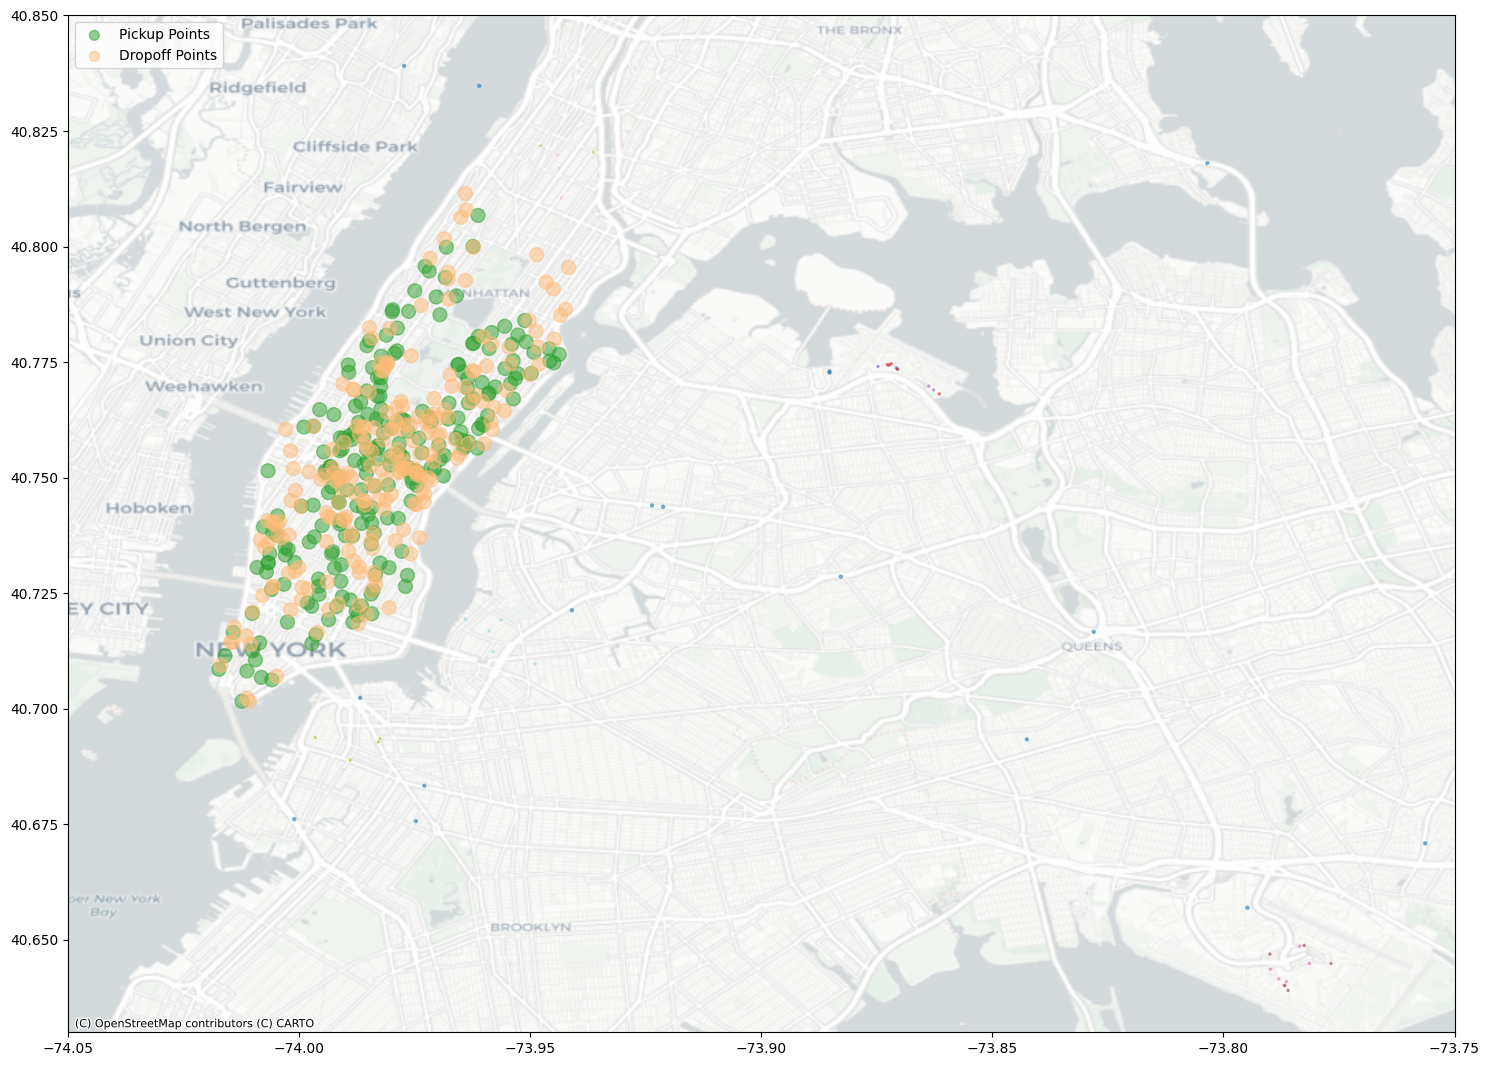

In [64]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import DBSCAN
import numpy as np


# Sample a subset of data, due to RAM exceeding gg collab allowance when set
# for all train data
sampled_data = data.sample(n=250, random_state=42)

sampled_data.rename(
    columns={'pickup_longitude': 'pickup_lon', 'pickup_latitude': 'pickup_lat',
             'dropoff_longitude': 'dropoff_lon', 'dropoff_latitude': 'dropoff_lat'},
    inplace=True
)

# Create GeoDataFrames
gdf_pickup = gpd.GeoDataFrame(sampled_data, geometry=gpd.points_from_xy(sampled_data.pickup_lon, sampled_data.pickup_lat))
gdf_dropoff = gpd.GeoDataFrame(sampled_data, geometry=gpd.points_from_xy(sampled_data.dropoff_lon, sampled_data.dropoff_lat))

# Set the CRS for both GeoDataFrames
gdf_pickup.set_crs(epsg=4326, inplace=True)
gdf_dropoff.set_crs(epsg=4326, inplace=True)

# Combine pickup and dropoff points for clustering
coords = np.vstack((gdf_pickup[['pickup_lon', 'pickup_lat']], gdf_dropoff[['dropoff_lon', 'dropoff_lat']]))

# DBSCAN clustering
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
labels = db.labels_

# Add labels to the GeoDataFrames
gdf_pickup['cluster'] = labels[:len(gdf_pickup)]
gdf_dropoff['cluster'] = labels[len(gdf_pickup):]

# Calculate cluster sizes & size column based on cluster size
pickup_cluster_sizes = gdf_pickup['cluster'].value_counts().to_dict()
dropoff_cluster_sizes = gdf_dropoff['cluster'].value_counts().to_dict()
gdf_pickup['size'] = gdf_pickup['cluster'].map(pickup_cluster_sizes)
gdf_dropoff['size'] = gdf_dropoff['cluster'].map(dropoff_cluster_sizes)

# Normalize the sizes for plotting
gdf_pickup['size'] = (gdf_pickup['size'] / gdf_pickup['size'].max()) * 100
gdf_dropoff['size'] = (gdf_dropoff['size'] / gdf_dropoff['size'].max()) * 100

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot pickup & dropoff points with clusters
gdf_pickup.plot(ax=ax, alpha=0.5, markersize=gdf_pickup['size'], column='cluster', cmap='tab20', label='Pickup Points')
gdf_dropoff.plot(ax=ax, alpha=0.5, markersize=gdf_dropoff['size'], column='cluster', cmap='tab20', label='Dropoff Points')

# From the longitude & latitude, New york city is the city of interest.
# Therefore, set the limits to focus on New York City
ax.set_xlim(-74.05, -73.75)
ax.set_ylim(40.63, 40.85)

# Add basemap & legends
ctx.add_basemap(ax, crs=gdf_pickup.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Archive

## **Diluar Kelas** - Evaluating prediction

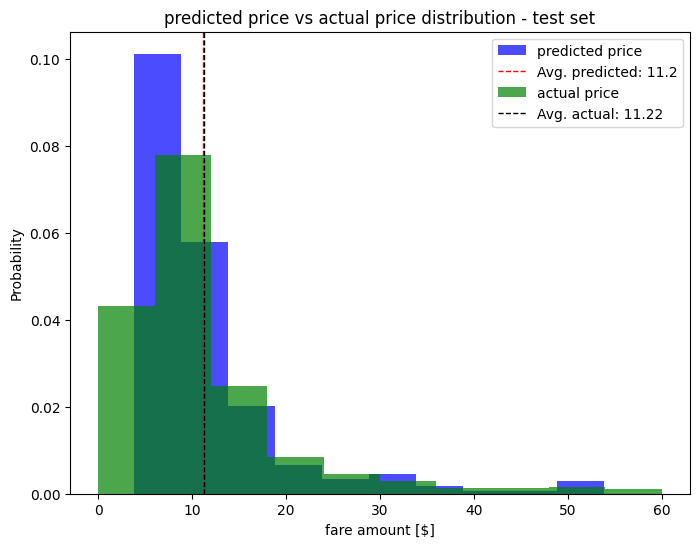

In [65]:
# setting figure size
plt.figure(figsize=(8,6
                    ))

# plotting for prediction
plt.hist(y_test_pred, color="blue", label="predicted price", alpha=0.7, density=True)
meean_predict = np.mean(y_test_pred)
plt.axvline(meean_predict, color='red', linestyle='dashed', linewidth=1, label=f'Avg. predicted: {round(meean_predict, 2)}')

# plotting for ground truth
plt.hist(y_test, color="green", label="actual price", alpha=0.7, density=True)
meean_label = np.mean(y_test)
plt.axvline(meean_label, color='black', linestyle='dashed', linewidth=1, label=f'Avg. actual: {round(meean_label, 2)}')

plt.title("predicted price vs actual price distribution - test set")
plt.ylabel("Probability")
plt.xlabel("fare amount [$]")
plt.legend()
plt.show()

so the result of model prediction is less than appealing due the model's predictions on average deviate from the actual fare amount by **3.97 USD**.

*   If we look at the distribution of fare shown at figure above, this deviation may seem non significant due to our model on average predicted the fare price ~50 cent less than the actual price. However, with higher transaction volume, the error in predicted fare added up to a $ -1.680 in business loss. This is not ideal.

*   Therefore, the current model is not appropriate to be used in the current operation. We should explore more solution to seek models that can fit under the current condition


*   first lets us re-assess the dataset and figure out where things might not be working so well. The first step is to find out the correlation between all the features we include above.

*   in this case we have DataFrame: **X_train_concant_fe** that have all cleaned features in a random distribution. Joined it with **y_train** to get a sample dataframe.











In [ ]:
concated_train = pd.concat([X_train_concat_fe, y_train], axis=1)
concated_train

,passenger_count,pickup_time_04-10,pickup_time_10-16,pickup_time_16-22,pickup_time_22-04,pickup_time_UNKNOWN,distance,fare_amount
order_id,,,,,,,,
51655713,2.0,0.0,0.0,1.0,0.0,0.0,0.073766,16.5
37525839,5.0,0.0,0.0,1.0,0.0,0.0,0.008585,3.7
55058970,1.0,0.0,0.0,1.0,0.0,0.0,0.075901,18.9
15663447,6.0,0.0,1.0,0.0,0.0,0.0,0.007733,4.1
13325650,1.0,0.0,0.0,1.0,0.0,0.0,0.011140,5.0
...,...,...,...,...,...,...,...,...
11639181,5.0,0.0,1.0,0.0,0.0,0.0,0.011660,6.5
35026129,1.0,0.0,0.0,1.0,0.0,0.0,0.016710,7.3
23008380,2.0,0.0,0.0,0.0,1.0,0.0,0.043137,10.9


In [ ]:
# run the default correlation matrix from pandas
corr_matrix = concated_train.corr()
corr_matrix['fare_amount'].sort_values(ascending=False)

fare_amount            1.000000
distance               0.024580
pickup_time_22-04      0.015721
passenger_count        0.013510
pickup_time_10-16      0.006163
pickup_time_UNKNOWN    0.002217
pickup_time_04-10      0.001476
pickup_time_16-22     -0.021357
Name: fare_amount, dtype: float64


*   **the result suggest that our features have almost to 0 correlation coefficient with the target output** (no strong linear relationship).

*   Distance feature was in general expected to correlate significantly with fare amount. But the result showed otherwise.


 its possible that the relationship can be better describe in other way such as through harvershine method. Other regression models are also open to be explored!

## **Diluar Kelas** - More Exploration

This part is intended to search for alternative features for our model and compare them based on performance and business impact. Here are some exploration objectives:

1. Explore the use of Harvershine method instead of Eucledian distance and predict the fare price with KNN

2. Explore other regression models using the new dataset - Decision Trees

3. Hyperparameter tuning of KNN with new dataset

## 1. Harvershine method

we can investigate further by calculating the distance of uber data in meters using Harversine method.


Haversine formula:
**a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)**

**c = 2 ⋅ atan2( √a, √(1−a) )**

**d = R ⋅ c**

where	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
note that angles need to be in radians to pass to trig functions!
JavaScript:

const R = 6371e3; // metres

const φ1 = lat1 * Math.PI/180; // φ, λ in radians

const φ2 = lat2 * Math.PI/180;

const Δφ = (lat2-lat1) * Math.PI/180;

const Δλ = (lon2-lon1) * Math.PI/180;


const a = Math.sin(Δφ/2) * Math.sin(Δφ/2) +
          Math.cos(φ1) * Math.cos(φ2) *
          Math.sin(Δλ/2) * Math.sin(Δλ/2);
          
const c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));

const d = R * c; // in metres

## Functions for Harvershine Methods

In [ ]:
def harversine_distance(dataframe):
    # set up constant parameters
    import math
    earth_rad = 6371e3 ;

    copy_data = deepcopy(dataframe)

    # Convert degrees to radians
    copy_data["pick_lat_rad"] = copy_data["pickup_latitude"].apply(math.radians)
    copy_data["pick_long_rad"] = copy_data["pickup_longitude"].apply(math.radians)
    copy_data["drop_lat_rad"] = copy_data["dropoff_latitude"].apply(math.radians)
    copy_data["drop_long_rad"] = copy_data["dropoff_longitude"].apply(math.radians)

    # Haversine formula
    copy_data["delta_phi"] = copy_data["drop_lat_rad"] - copy_data["pick_lat_rad"]
    copy_data["delta_lambda"] = copy_data["drop_long_rad"] - copy_data["pick_long_rad"]
    a = copy_data["delta_phi"].apply(lambda x: math.sin(x / 2) ** 2) + copy_data["pick_lat_rad"].apply(math.cos) * copy_data["drop_lat_rad"].apply(math.cos) * copy_data["delta_lambda"].apply(lambda x: math.sin(x / 2) ** 2)
    c = 2 * copy_data["delta_phi"].apply(lambda x: math.atan2(math.sqrt(abs(x)), math.sqrt(abs(1 - x))))
    distance = earth_rad * c

    copy_data["distance_[m]"] = distance

    final_df = copy_data.drop(columns=["pickup_latitude", "dropoff_latitude",
                                       "pickup_longitude", "dropoff_longitude",
                                       "pick_lat_rad", "pick_long_rad",
                                       "drop_lat_rad", "drop_long_rad",
                                       "delta_phi", "delta_lambda"])
    return final_df


In [ ]:
new_df = deepcopy(data)
harv_df = harversine_distance(new_df)
harv_df.head(3)

,fare_amount,pickup_time,passenger_count,distance_[m]
order_id,,,,
24238194,7.5,16-22,1.0,207060.169605
27835199,7.7,16-22,1.0,250265.131103
44984355,12.9,16-22,1.0,300576.680960


In [ ]:
harv_df.shape

(194814, 4)

In [ ]:
# Compute pairwise correlation of columns
correlation_matrix = harv_df.select_dtypes(include=np.number).corr()
correlation_matrix["fare_amount"].sort_values(ascending=False)

fare_amount        1.000000
distance_[m]       0.311651
passenger_count    0.013910
Name: fare_amount, dtype: float64

congrats, our correlation value **increased to 0.31**! at least we know our prediction will be somewhat better than previous model. Moreover, we can delete missing data from rows that have missing info on passanger count because this feature have no correlation to fare_amount

## EDA Harvershine

In [ ]:
harv_df.isna().sum()

fare_amount           0
pickup_time           0
passenger_count    1200
distance_[m]          0
dtype: int64

missing passanger count

In [ ]:
harv_df["passenger_count"].dropna(inplace=True)
print(len(harv_df))

194814


missing pickup time

In [ ]:
harv_df["pickup_time"].value_counts() ## delete all datapoints with missing pickup time

pickup_time
16-22    63834
10-16    55861
22-04    43209
04-10    30710
-         1200
Name: count, dtype: int64

In [ ]:
harv_df = harv_df[harv_df['pickup_time'].isin(['16-22', '10-16', '22-04', '04-10'])]
harv_df

,fare_amount,pickup_time,passenger_count,distance_[m]
order_id,,,,
24238194,7.5,16-22,1.0,207060.169605
27835199,7.7,16-22,1.0,250265.131103
44984355,12.9,16-22,1.0,300576.680960
25894730,5.3,04-10,3.0,188249.543425
17610152,16.0,16-22,5.0,220537.230640
...,...,...,...,...
42598914,3.0,10-16,1.0,51335.634442
16382965,7.5,22-04,1.0,88804.792443
27804658,30.9,22-04,2.0,425128.368678


split input and output

In [ ]:
df_no_missing = harv_df.dropna(subset=['passenger_count'])
''
print(len(harv_df))
print(len(df_no_missing))

193614
192426


In [ ]:
X_2, y_2 = split_input_output(data=df_no_missing, target_col='fare_amount')

(X) Input shape: (192426, 3)
(y) Output shape: (192426,)


## Pre-Process Harvershine

**Split into Training, Validation & Test set**

In [ ]:
X_train2, X_not_train2, y_train2, y_not_train2 = split_train_test(X_2, y_2, 0.2, 123) # WRITE YOUR CODE HERE, Use seed=123

# Then, split the valid & test
X_valid2, X_test2, y_valid2, y_test2 = split_train_test(X_not_train2, y_not_train2, 0.5, 123)  # WRITE YOUR CODE HERE, Use seed=123

# print out result
print(f"X train shape:{X_train2.shape} with portion of {round(len(X_train2) / len(X),4)}")
print(f"y train shape:{y_train2.shape} with portion of {round(len(y_train2) / len(y),4)}")
print("")

print(f"X valid shape: {X_valid2.shape} with portion of {round(len(X_valid2) / len(X),4)}")
print(f"y valid shape: {y_valid2.shape} with portion of {round(len(y_valid2) / len(y),4)}")
print("")

print(f"X test  shape: {X_test2.shape} with portion of {round(len(X_test2) / len(X),4)}")
print(f"y test  shape: {y_test2.shape} with portion of {round(len(y_test2) / len(y),4)}")

X train shape:(153940, 3) with portion of 0.7902
y train shape:(153940,) with portion of 0.7902

X valid shape: (19243, 3) with portion of 0.0988
y valid shape: (19243,) with portion of 0.0988

X test  shape: (19243, 3) with portion of 0.0988
y test  shape: (19243,) with portion of 0.0988


preprocess categorical & numerical features

In [ ]:
def preprocess_data_harv(data):
  num_df = data.select_dtypes(include=np.number)
  cat_df = data.select_dtypes(exclude=np.number)

  encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

  encoder.fit(cat_df)

  encoded = encoder.transform(cat_df)

  cat_encoded = pd.DataFrame(encoded,

                             columns=encoder.get_feature_names_out(
                                 input_features=cat_df.columns
                             ),
                             index=cat_df.index
                             )

  joined_df = pd.concat([num_df, cat_encoded], axis=1)

  scaler = StandardScaler()

  scaled_data = scaler.fit_transform(joined_df)

  scaled_df = pd.DataFrame(scaled_data, columns=joined_df.columns, index=joined_df.index)


  # validation print out
  print(f"Original datashape: {data.shape}")
  print(f"Numerical datashape: {num_df.shape}")
  print(f"Categorical datashape: {cat_df.shape}")
  print(f"final DF datashape: {scaled_df.shape}")
  print(" ")

  return scaled_df




In [ ]:
X_train2_clean = preprocess_data_harv(data=X_train2)
#X_valid2_clean = harv_preprocessing(X_valid2)
#X_test2_clean = harv_preprocessing(X_test2)

Original datashape: (153940, 3)
Numerical datashape: (153940, 2)
Categorical datashape: (153940, 1)
final DF datashape: (153940, 6)
 


In [ ]:
X_valid2_clean = preprocess_data_harv(data=X_valid2)
X_test2_clean = preprocess_data_harv(data=X_test2)

Original datashape: (19243, 3)
Numerical datashape: (19243, 2)
Categorical datashape: (19243, 1)
final DF datashape: (19243, 6)
 
Original datashape: (19243, 3)
Numerical datashape: (19243, 2)
Categorical datashape: (19243, 1)
final DF datashape: (19243, 6)
 


In [ ]:
# last test
print(len(X_train2_clean))
print(len(y_train2))
print("")
print(len(X_valid2_clean))
print(len(y_valid2))
print("")
print(len(X_test2_clean))
print(len(y_test2))
print("")
#### dataset ok! every input and output length match! Lets train!

153940
153940

19243
19243

19243
19243



setting train model

In [ ]:
reg_11 = KNeighborsRegressor(n_neighbors=1)
reg_12 = KNeighborsRegressor(n_neighbors=100)
reg_13 = KNeighborsRegressor(n_neighbors=200)
reg_14 = KNeighborsRegressor(n_neighbors=500)
reg_15 = KNeighborsRegressor(n_neighbors=25)
reg_16 = KNeighborsRegressor(n_neighbors=95)


In [ ]:
train_model(reg_11, X_train2_clean, y_train2)# mean
train_model(reg_12, X_train2_clean, y_train2)# 100
train_model(reg_13, X_train2_clean, y_train2)# 200
train_model(reg_14, X_train2_clean, y_train2)# 500
train_model(reg_15, X_train2_clean, y_train2)# hyperparameter # 1: 25
train_model(reg_16, X_train2_clean, y_train2)# hyperparameter # 2. 95

In [ ]:
# Return validation (JUST RUN THE CODE)
import time

for reg in [reg_11, reg_12, reg_13, reg_14, reg_15, reg_16]:
    t0 = time.time()

    # Generate the rmse
    rmse_train, rmse_valid = evaluate_model(estimator=reg,
                                            in_train=X_train2_clean,
                                            out_train=y_train2,
                                            in_val=X_valid2_clean,
                                            out_val=y_valid2)

    # Logging
    elapsed = time.time() - t0
    print(f'model : {str(reg):40s} '
          f'| RMSE train: {rmse_train:.4f} '
          f'| RMSE valid: {rmse_valid:.4f} '
          f'| Time elapsed: {elapsed*1000:.2f} ms')

model : KNeighborsRegressor(n_neighbors=1)       | RMSE train: 2.1940 | RMSE valid: 8.9150 | Time elapsed: 16436.47 ms
model : KNeighborsRegressor(n_neighbors=100)     | RMSE train: 6.1524 | RMSE valid: 6.4556 | Time elapsed: 26820.43 ms
model : KNeighborsRegressor(n_neighbors=200)     | RMSE train: 6.2010 | RMSE valid: 6.4700 | Time elapsed: 39222.23 ms
model : KNeighborsRegressor(n_neighbors=500)     | RMSE train: 6.3456 | RMSE valid: 6.5973 | Time elapsed: 71370.27 ms
model : KNeighborsRegressor(n_neighbors=25)      | RMSE train: 6.0282 | RMSE valid: 6.5080 | Time elapsed: 20699.51 ms
model : KNeighborsRegressor(n_neighbors=95)      | RMSE train: 6.1485 | RMSE valid: 6.4533 | Time elapsed: 25967.48 ms


In [ ]:
best_regre = reg_16

In [ ]:
y_test2_pred = best_regre.predict(X_test2_clean)

In [ ]:
print(len(y_test2_pred))
print(len(y_test2))

19243
19243


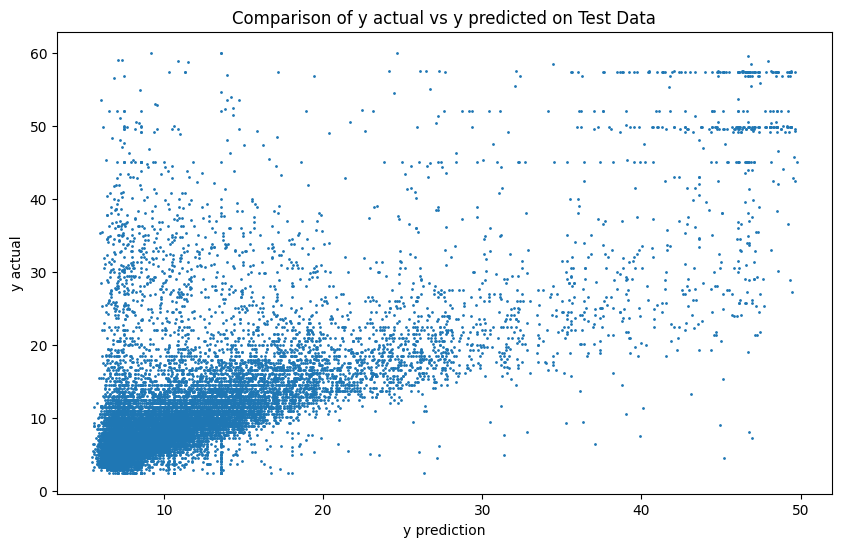

In [ ]:
#visualize prediction result
plt.figure(figsize=(10,6))
plt.scatter(y_test2_pred, y_test2, s=1)
plt.title("comparison predict and actual")
plt.xlabel('y prediction'); plt.ylabel('y actual')
plt.title('Comparison of y actual vs y predicted on Test Data')
plt.show()

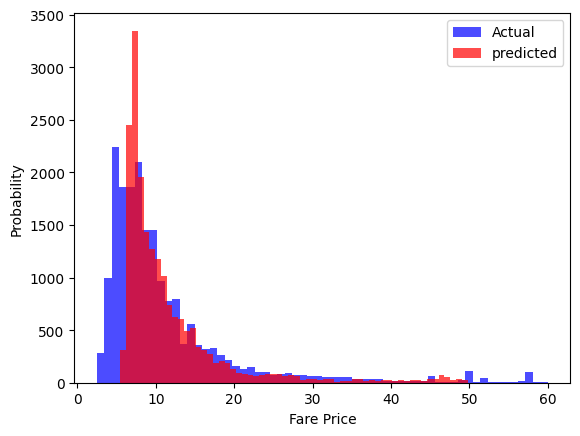

In [ ]:
# visulaize using histogram
plt.hist(y_test2, bins=60, color="blue", alpha=0.7, density=False, label="Actual")
plt.hist(y_test2_pred, bins=60, color="red", alpha=0.7, density=False, label="predicted")
plt.legend()
plt.xlabel("Fare Price")
plt.ylabel("Probability")
plt.show()

In [ ]:
# Calculate the difference in fare price
diff_fare_test = y_test2_pred.sum() - y_test2.sum()
final_diff = round(diff_fare_test,2)
print(f"Difference between predicted price and actual price are: ${final_diff}")

Difference between predicted price and actual price are: $9973.7


#### hyperparameter search

In [ ]:


# Define the model
knn = KNeighborsRegressor()

grid = [i for i in range(5,500,5)]

# Define the parameter grid
param_grid = {
    'n_neighbors': grid,
    'weights': ['uniform', 'distance']
}

# Define the GridSearchCV object
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')

# Assume X_train2_clean, y_train2 are your training data
grid_knn.fit(X_train2_clean, y_train2)

# To get the best parameters combination
best_parameters = grid_knn.best_params_

# To get the best score achieved
best_score = grid_knn.best_score_

print(f"best hyperparameter: {best_parameters}")
print(f"best score: {best_score}")

best hyperparameter: {'n_neighbors': 95, 'weights': 'uniform'}
best score: -38.71451981970045


## 2 & 3. Explore other regression models with hyperparameter tuning
---
In the previous exercise we have used KNN models to predict fare prices. But can we get better result with other models? lets find out! our goal is to use several common regression models mentioned above

### 2 Decision Tree Regression

In [ ]:
# import libraries for Decision Trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

def evaluate_model_DT_hrv(estimator,
                   X_train,
                   y_train,
                   X_valid,
                   y_valid):

    estimator.fit(X_train2_clean, y_train2)

    y_train_predict2 = estimator.predict(X_train2_clean)
    rmse_train = mean_squared_error(y_train2, y_train_predict2)**0.5

    y_valid_predict2 = estimator.predict(X_valid2_clean)
    rmse_valid = mean_squared_error(y_valid2, y_valid_predict2)**0.5

    return rmse_train, rmse_valid

In [ ]:
### Chat GPT Hyperparameter search
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid
param_grid = {
    'max_depth': list(range(3, 15)),  # usually a shallower tree is better to prevent overfitting
    'min_samples_split': [2, 5, 10, 20],  # a bigger value might help to prevent overfitting as well
    'min_samples_leaf': [1, 2, 5, 10],  # often the lower the leaf size, the better the model learns the train data
    'criterion' : ['squared_error']  # both can be tested to check which one gives better results
}

# Create DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=123)

# Define the scoring metric (negative mean squared error)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=scoring, cv=5)
grid_search.fit(X_train2_clean, y_train2)  # Assuming X_train and y_train are your training data

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}


before hyperparameter search

In [ ]:
# First iteration before hyperparameter search
Tree_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=123)

In [ ]:
t0 = time.time()

RMSE_train, RMSE_valid = evaluate_model_DT_hrv(estimator=Tree_reg,
                                             X_train=X_train2_clean,
                                             y_train=y_train2,
                                             X_valid=X_valid2_clean,
                                             y_valid=y_valid2)

#      Logging
elapsed = time.time() - t0
print(f'model : {str(Tree_reg):40s} '
      f'| RMSE train: {RMSE_train:.4f} '
      f'| RMSE valid: {RMSE_valid:.4f} '
      f'| Time elapsed: {elapsed*1000:.2f} ms')

model : DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=123) | RMSE train: 6.0332 | RMSE valid: 6.4753 | Time elapsed: 342.12 ms


After hyperparamter search

In [ ]:
# second iteration after using hyperparameter search
Tree_reg_hyp = DecisionTreeRegressor(max_depth=5,
                                     min_samples_split=2,
                                     min_samples_leaf=10,
                                     random_state=123)

In [ ]:
t0 = time.time()

RMSE_train_h, RMSE_valid_h = evaluate_model_DT_hrv(estimator=Tree_reg_hyp,
                                             X_train=X_train2_clean,
                                             y_train=y_train2,
                                             X_valid=X_valid2_clean,
                                             y_valid=y_valid2)

#      Logging
elapsed = time.time() - t0
print(f'model : {str(Tree_reg_hyp):40s} '
      f'| RMSE train: {RMSE_train_h:.4f} '
      f'| RMSE valid: {RMSE_valid_h:.4f} '
      f'| Time elapsed: {elapsed*1000:.2f} ms')

model : DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=123) | RMSE train: 6.1597 | RMSE valid: 6.4362 | Time elapsed: 197.83 ms


From this experience RMSE value indicate that the performance of our tree-based model performs similarly with new KNN. However noticable improvement in computing time was very apparent (~23.937% faster in computing speed)


##### Archieved
---

check the distribution of **fare_amount**

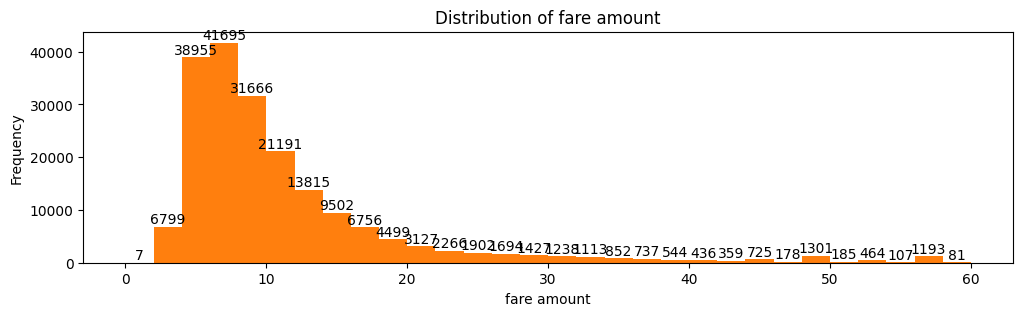

In [ ]:
ax = data["fare_amount"].plot(kind="hist",
                      title="Distribution of fare amount",
                      bins=30, figsize=(12,3)
                      )
ax.set_xlabel("fare amount")

# Annotate each bin with its count
counts, bins, patches = ax.hist(data["fare_amount"], bins=30, density=False)
for count, bin, patch in zip(counts, bins, patches):
    ax.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')

from the graph above, there are 7 instances where über rides are given almost without compensation. lets investigate more about this case

In [ ]:
df_inves = data.query("fare_amount < 1")
drop_idx = df_inves.index
df_inves

,fare_amount,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,,
25344154,0.00,22-04,-73.658897,40.805199,-73.658897,40.805199,1.0
46896458,0.01,16-22,-73.991692,40.770802,-73.991692,40.770824,1.0
22994576,0.00,22-04,-73.994366,40.755395,-73.998718,40.854853,2.0
10649069,0.00,22-04,-73.969475,40.807503,0.000000,0.000000,2.0
46581076,0.11,16-22,-73.997221,40.721345,-73.997252,40.721344,1.0
36776406,0.00,04-10,-73.937714,40.758541,-73.937721,40.758541,1.0
27919562,0.01,16-22,-74.000523,40.725868,-73.956960,40.780855,1.0


simplest way to go about this data is to eliminate it. Giving customer a free ride is possible under some circumstances (coupon code / specific campaign), however within the current features its almost impossible to give justification why this fare were given at almost no cost. Therefore, we can eliminate this data altogether.

##### Archieved-2
---


In [ ]:
def percent_missing_values(dataframe):
    """
    Calculate the percentage of missing values in each column of a DataFrame.
    """
    missing_value_info = []  # List to store missing value information

    for col in dataframe.columns:
        # catch missing value type na, None and ""
        missing_values = dataframe[col].isna().sum() + \
                         dataframe[col].eq(None).sum() + \
                         (dataframe[col] == '').sum()

        # calculate percentage of missing per colum
        percentage_missing = (missing_values / len(dataframe)) * 100
        print(f"{round(percentage_missing, 2)}% missing values of {col}") ; print("")

percent_missing_values(new_df)

0.0% missing values of fare_amount

0.0% missing values of pickup_time

0.0% missing values of pickup_longitude

0.0% missing values of pickup_latitude

0.0% missing values of dropoff_longitude

0.0% missing values of dropoff_latitude

0.62% missing values of passenger_count



In [ ]:
missing_val_df = new_df[new_df['passenger_count'].isna()]
missing_val_df

,fare_amount,pickup_time,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
order_id,,,,,,,
30869427,7.3,22-04,-74.008325,40.725947,-73.988232,40.720322,NaN
41458016,6.5,10-16,-73.999166,40.739403,-73.988351,40.743763,NaN
39648057,19.3,22-04,-73.995176,40.750516,-73.971411,40.680955,NaN
40451656,6.9,-,-73.993640,40.746775,-73.975835,40.733528,NaN
841204,9.0,04-10,-73.987023,40.754192,-73.978762,40.739462,NaN
...,...,...,...,...,...,...,...
8456259,7.7,16-22,-73.994200,40.751100,-73.983000,40.765200,NaN
29279997,23.5,22-04,-73.968115,40.801455,0.000000,0.000000,NaN
50282059,19.3,16-22,-73.971775,40.752417,-73.892398,40.740870,NaN


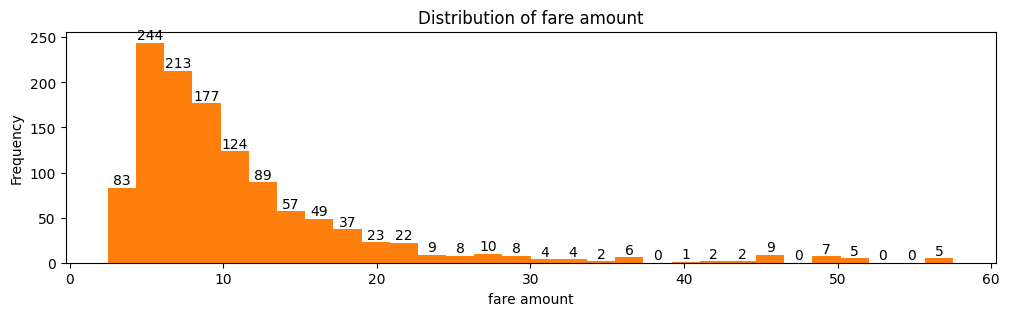

In [ ]:
bx = missing_val_df["fare_amount"].plot(kind="hist",
                      title="Distribution of fare amount",
                      bins=30, figsize=(12,3)
                      )
bx.set_xlabel("fare amount")

# Annotate each bin with its count
counts, bins, patches = bx.hist(missing_val_df["fare_amount"], bins=30, density=False)
for count, bin, patch in zip(counts, bins, patches):
    bx.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom')